In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import Image


# Diffusion Models from (nearly) Scratch

Assume that we have a dataset, and we want to learn the probability distribution of this dataset so we can sample from it and get new data points.


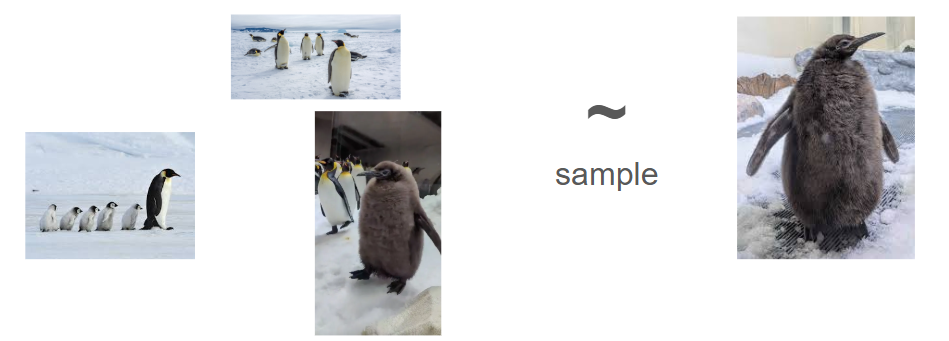

We can try to estimate the probability density function (pdf) of our distribution
pdfs are non negative and sum/integrate to one.
The most common pdf you will see is the normal distribution, given by


$\mathcal{N} ~ (\mu,\sigma) = \dfrac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

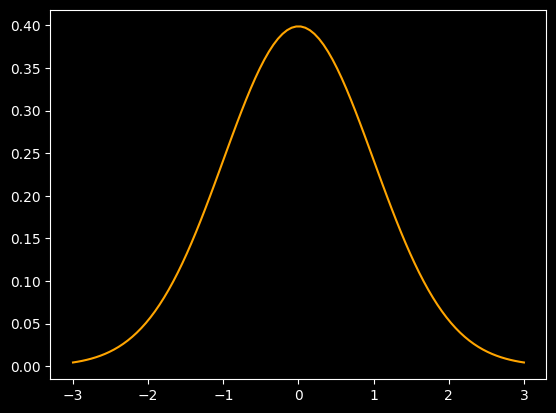

In [ ]:
plt.style.use('dark_background')
plt.plot(x:=jnp.linspace(-3,3,100), jnp.exp(-(x**2)/2)/jnp.sqrt(2*jnp.pi), color='orange'); plt.show()

If we have the underlying (parameterized) pdf of our dataset, we can sample from our distribution. Let's call the pdf of our dataset $p(x)$.

This is unknown, so we will model it with $p_\theta (x)$, where $\theta$ is the paramaters of our model.

A good, lazy way to parameterize it is $p_\theta (x) = \dfrac{e^{-f_\theta(x)}}{{Z_\theta}}$

This meets our pdf criteria from before, as the exponential is always positive, and we can find some normalizing constant $Z_\theta$ to allow the pdf to integrate to 1.

Intuitively, you can imagine that the $e^{-f_\theta(x)}$ takes on large values where our data is dense (the probability of being there is high) and small values where our data is sparse.

Ideally we could simply learn $f_\theta$, but the normalizing constant $Z_\theta$ makes this problem intractable. In order to determine $Z_\theta$, we would need to normalize over the entire space of $x$, which is generally high dimensional.

There are a few approaches around this, approximate $Z_theta$ or restrict our $f_\theta$, but the approach we will discuss is the score function.

## Score

The score of $p_\theta (x)$ is given by $\nabla_x \log p_\theta(x)$

Why use the score? When we plug in our estimator, we can see it makes life much easier.

$\nabla_x \log p_\theta(x) = \nabla_x \log \dfrac{e^{-f_\theta(x)}}{{Z_\theta}}$

By log rules for division

$ = \nabla_x \log e^{-f_\theta(x)} - \nabla_x \log {Z_\theta} $

But $Z_theta$ has no dependence on X, and we can apply the log rules for exponentials

$ = \nabla_x \log e^{-f_\theta(x)} - 0$

$ s_\theta (x) = -\nabla_x f_\theta(x)$

## Score Matching

So instead of directly predicting our distribution $p(x)$ with $p_theta(x)$, we are going to match the score of $p(x)$ with the score of $p_theta$.

So what does that look like? We want to minimize

$\frac{1}{2}\mathop{\mathbb{E}}_{p_x}\left[\lVert \nabla_x \log p(x) - s_\theta(x) \rVert^2_2 \right]$

So this is all fine, but what exactly are we optimizing for when we optimize for the score?

The term $\nabla_x \log p(x)$ tells you what direction a point should move in order to increase it's probability.

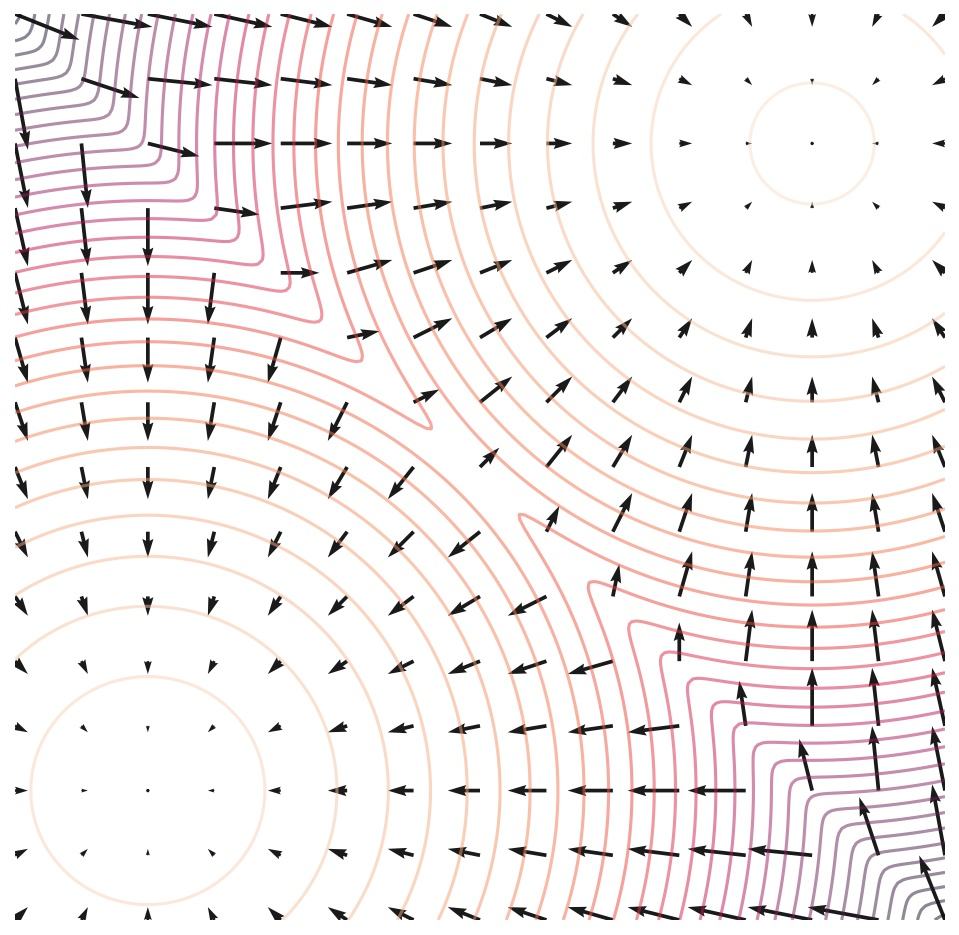

Now a core problem is we don't actually have access to $\nabla_x \log p(x)$ because we don't have $p(x)$. It is, however, possible to rewrite the score function without it.


$\frac{1}{2}\mathop{\mathbb{E}}_{p(x)}\left[\lVert \nabla_x \log p(x) - s_\theta(x) \rVert^2_2 \right]$

Convert the expectation into an integral and expand out the square.

$\frac{1}{2}\int p(x) \nabla_x \log p(x)^2+s_\theta(x)^2 -2\nabla_x \log p(x)s_\theta(x)dx$

Split the integrals

$\frac{1}{2}\int p(x) \nabla_x \log p(x)^2dx+\frac{1}{2}\int s_\theta(x)^2dx -\int \nabla_x \log p(x)s_\theta(x)dx$

Apply this useful identity (chain rule) $\nabla_x \log p(x) = \dfrac{\nabla_x p(x)}{p(x)}$ to the last term

$\int \nabla_x \log p(x)s_\theta(x)dx = \int \dfrac{\nabla_x p(x)}{p(x)} s_\theta(x)dx = \int \nabla_x p(x)s_\theta(x)dx$

Apply integration by parts

$\int \nabla_x p(x)s_\theta(x)dx = \left[ p(x)s(x)\right]^\infty_{-\infty} + \int p(x) \nabla_x s_\theta(x)dx$

Assuming that our distribution has compact support (or at least has rapidly decaying support), the first term evaluates to 0.

$\int \nabla_x p(x)s_\theta(x)dx = \int p(x) \nabla_x s_\theta(x)dx$

Plugging this back into our original equation

$\frac{1}{2}\int p(x) \nabla_x \log p(x)^2dx+\frac{1}{2}\int s_\theta(x)^2dx - \int p(x) \nabla_x s_\theta(x)dx$

Note that the first term does not depend on $\theta$, our optimization variable. So this is a constant, and we can ignore it.

$\frac{1}{2}\int s_\theta(x)^2dx - \int p(x) \nabla_x s_\theta(x)dx$

Nowe we can convert our integrals back into expectations

$\frac{1}{2}\mathop{\mathbb{E}}_{p(x)}\left[s_\theta(x)^2\right] + \mathop{\mathbb{E}}_{p(x)}\left[\nabla_x s_\theta(x)\right]$

And so we don't need the original score.

These two terms should make some intuitive sense. The second term $\mathop{\mathbb{E}}_{p_x}\left[\nabla_x s_\theta(x)\right]$ tries to make the gradient of the score model at data points should be 0, which ought to be a maximum.

The first term tries to max the predicted score 0 at data points. The score tells you what direction to move, so when you are at a data point you shouldn't move.

Now there are still two problems with this approach.

1: We still have to compute $\nabla_x s_\theta(x)$. This is extremely expensive, requiring us to compute the Jacobian.

2: When we train, we don't usually see points outside our data distribution. This is a problem when sampling, as we (almost certainly) will wind up in a spot not covered by our dataset in very high dimensions.

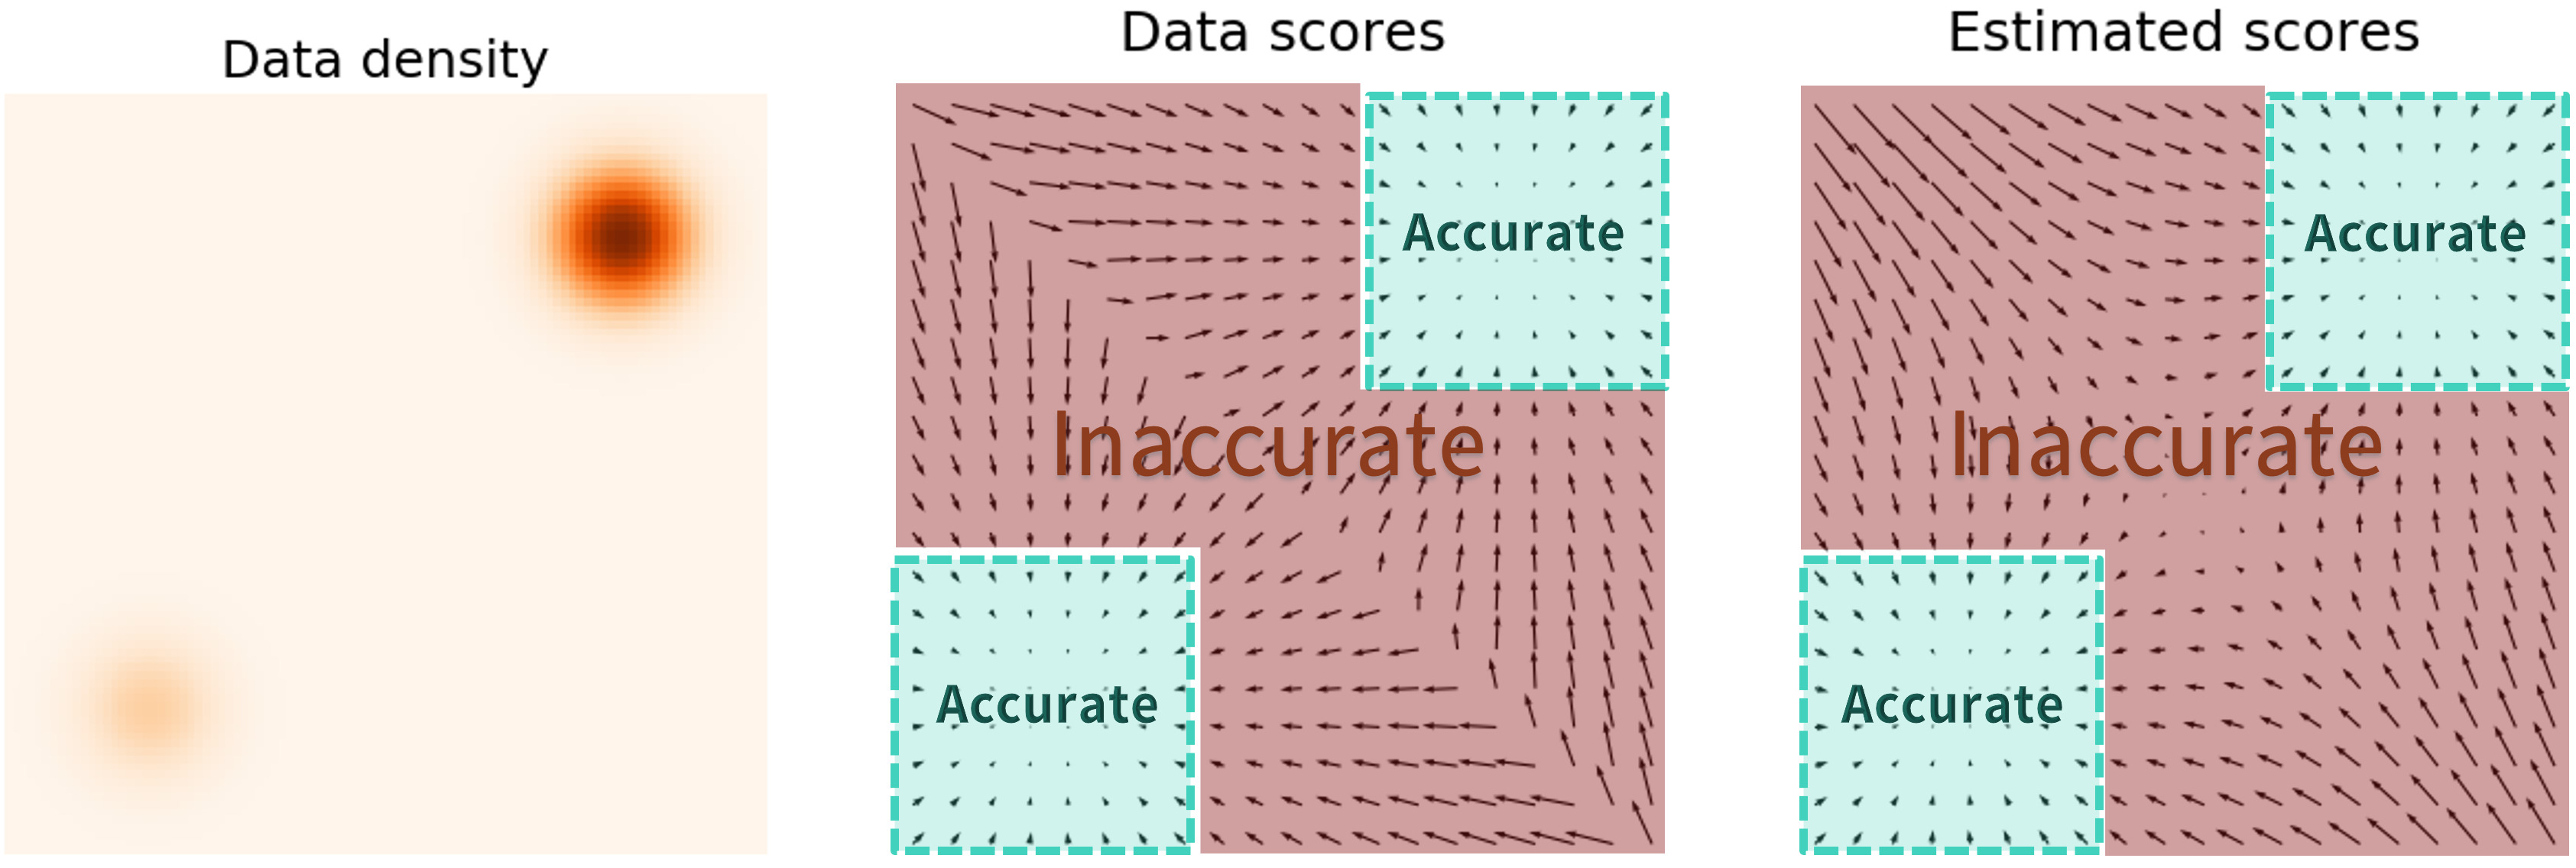

The model has never seen these areas during training, so it will estimate poorly in these areas.

To solve the second problem, we can inject noise. We can do this by taking all of our points and adding gaussian nosie to all of them.

Formally, we will change our dataset to $\tilde{x} = x + \epsilon$ where $\epsilon = \mathcal N \sim (0, \sigma^2 I)$

So instead of $p(x)$ we now have $p_\sigma(\tilde x)$ and we update our optimization function accordingly

$\frac{1}{2}\mathop{\mathbb{E}}_{p_\sigma (\tilde{x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) - s_\theta(\tilde{x}) \rVert^2_2 \right]$

This peturbed distribution allows the model to 'see' more of the sample space and learn the score function. The amount of noise we add is determined by $\sigma$.

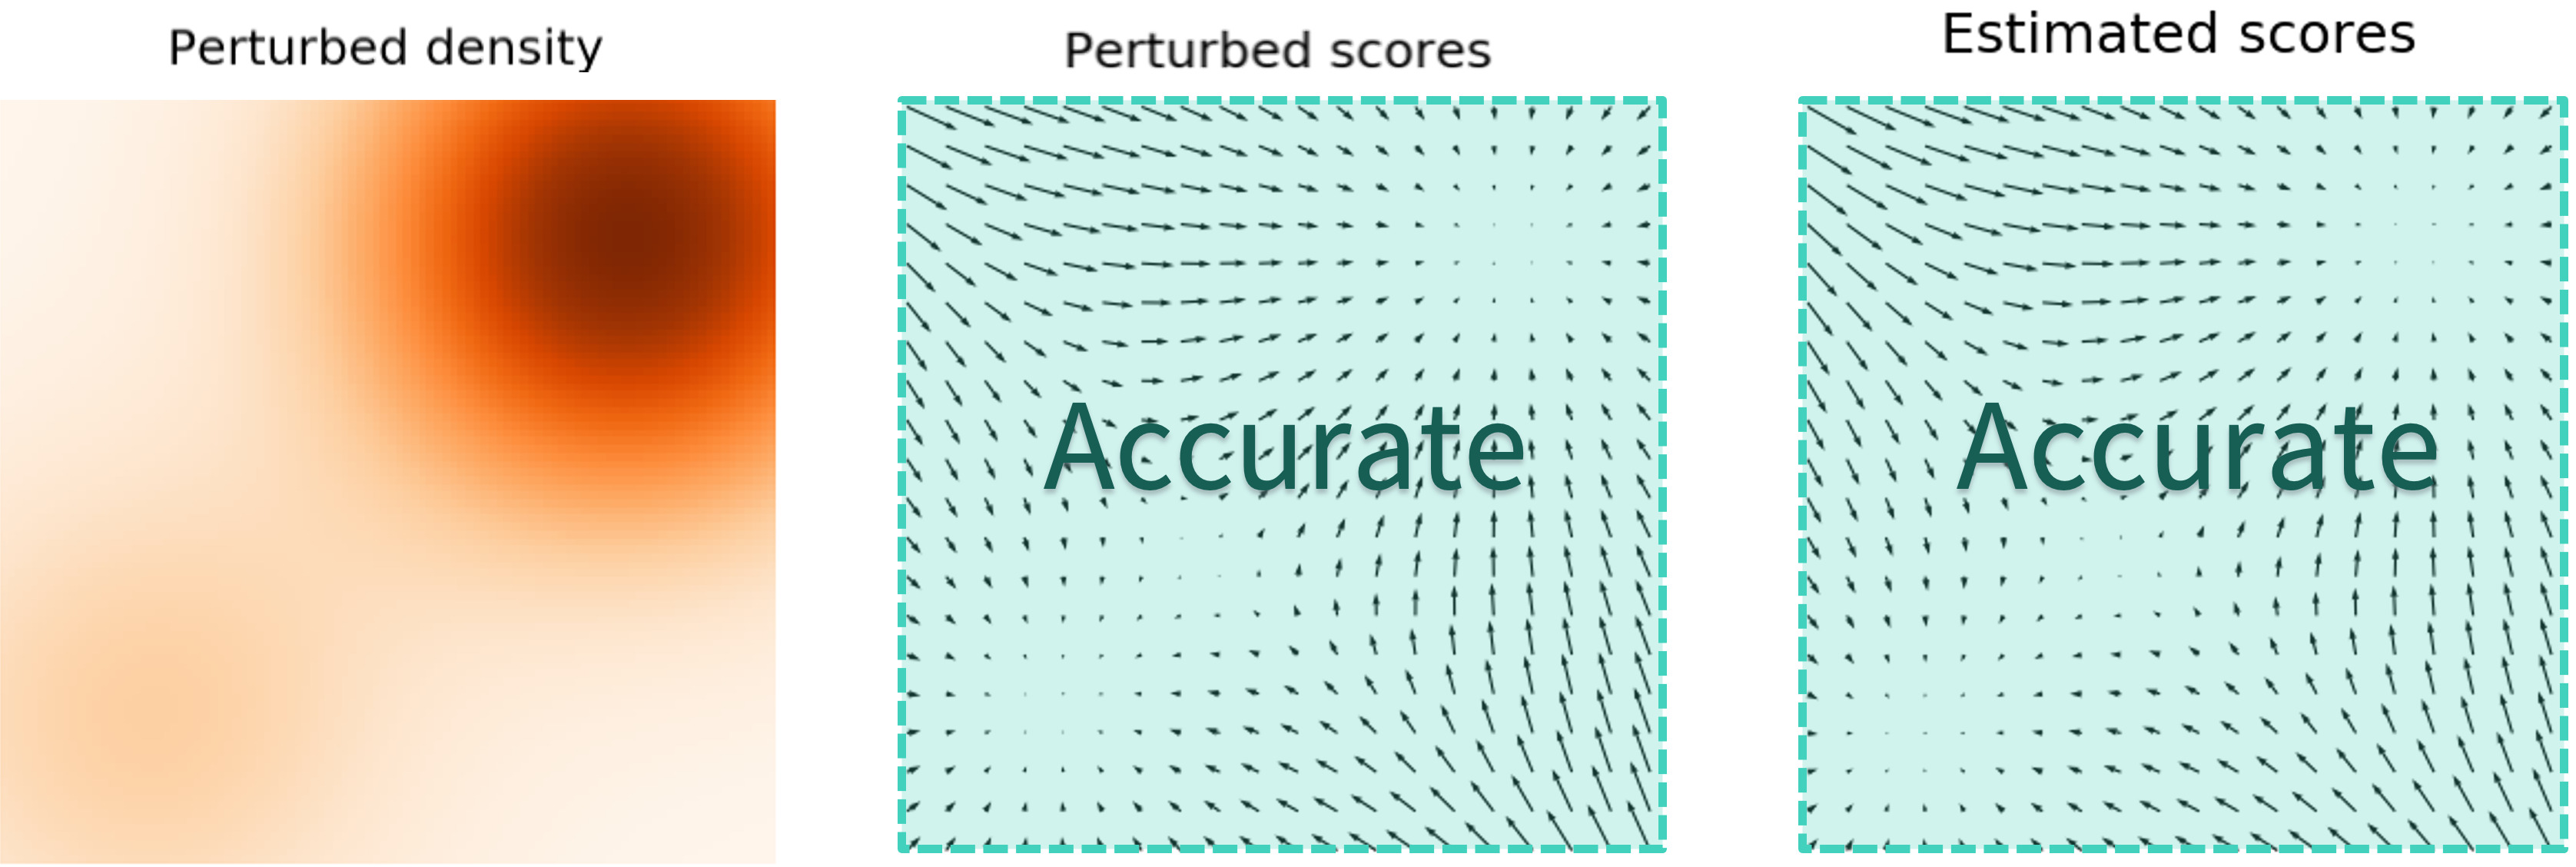

Note that $\sigma$ is a single value that we pick. If we pick a large $\sigma$, we cover more of the data space, but we corrupt our data and shift our distribution. If we pick $\sigma$ too small we don't cover enough of the space.

Now we return to the first problem, which is that evaluating $\nabla_x s_\theta(x)$ is extremely expensive. It turns out that our new objective function gives us a way around this.

$\frac{1}{2}\mathop{\mathbb{E}}_{p_\sigma (\tilde{x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) - s_\theta(\tilde{x}) \rVert^2_2 \right]$

(Long derivation)

Once again, we rewrite the expectation as the integral

$\frac{1}{2} \int p_\sigma (\tilde{x})\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) - s_\theta(\tilde{x}) \rVert^2_2 d\tilde{x} $

Expand

$\frac{1}{2} \int p_\sigma (\tilde{x}) \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})^2 d\tilde{x} +\frac{1}{2} \int p_\sigma (\tilde{x}) s_\theta(\tilde{x})^2  d\tilde{x} -
\int p_\sigma (\tilde{x}) \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) s_\theta(\tilde{x})d\tilde{x}$

Let's look at the last term

$\int p_\sigma (\tilde{x}) \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) s_\theta(\tilde{x})d\tilde{x}$

Use the same chain rule trick

$\int p_\sigma(\tilde x)\dfrac{\nabla_{\tilde x} p_\sigma(\tilde x)}{p_\sigma(\tilde x)}  s_\theta(\tilde{x})d\tilde{x}$

Cancel

$\int \nabla_{\tilde x} {p_\sigma(\tilde x)}   s_\theta(\tilde{x})d\tilde{x}$

Marginalize $p_\sigma(\tilde x) = \int p(x) p_\sigma(\tilde x|x)d\tilde{x}$

$\int \nabla_{\tilde x} \left(\int p(x) p_\sigma(\tilde x|x)dx\right)   s_\theta(\tilde{x})d\tilde{x}$

By Leibniz Integration rule, $p(x)$ does not depend on $\tilde{x}$

$\int \left(\int p(x) \nabla_{\tilde x} p_\sigma(\tilde x|x)dx\right)   s_\theta(\tilde{x})dx$

Note that our chain rule trick can be rewritten:

$\nabla_x \log p(\tilde x |x) = \dfrac{\nabla_{\tilde{x}} p(\tilde x |x)}{p(\tilde x |x)} \implies p(\tilde x |x)\nabla_{\tilde{x}} \log p(\tilde x |x) =\nabla_x p(\tilde x |x) $

So we rewrite the integral as

$\int \left(\int p(x) p(\tilde x |x)\nabla_{\tilde{x}} p_\sigma(\tilde x|x)dx\right)  s_\theta(\tilde{x})d\tilde x$

By linearity of the integral

$\iint p(x) p(\tilde x |x)\nabla_{\tilde{x}} p_\sigma(\tilde x|x)s_\theta(\tilde{x})dx d\tilde x$

Plug it into the formula

$\frac{1}{2} \int p_\sigma (\tilde{x}) \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})^2 d\tilde{x} +\frac{1}{2} \int p_\sigma (\tilde{x}) s_\theta(\tilde{x})^2  d\tilde{x} -
\iint p(x) p(\tilde x |x)\nabla_{\tilde{x}} p_\sigma(\tilde x|x)s_\theta(\tilde{x})dx d\tilde x$

Convert back to expectations (almost done)

$\frac{1}{2}\mathop{\mathbb{E}}_{\tilde x \sim p_\sigma (\tilde{x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})\rVert^2_2 \right] +
\frac{1}{2}\mathop{\mathbb{E}}_{\tilde x \sim p_\sigma (\tilde{x})}\left[\lVert s_\theta(\tilde{x}) \rVert^2_2 \right] -
\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) s_\theta(\tilde{x}) \rVert^2_2 \right]$

We apply marginalization on the second term so the expectations match

$\frac{1}{2}\mathop{\mathbb{E}}_{\tilde x \sim p_\sigma (\tilde{x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})\rVert^2_2 \right] +
\frac{1}{2}\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[\lVert s_\theta(\tilde{x}) \rVert^2_2 \right] -
\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) s_\theta(\tilde{x}) \rVert^2_2 \right]$

Combine

$\frac{1}{2}\mathop{\mathbb{E}}_{\tilde x \sim p_\sigma (\tilde{x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})\rVert^2_2 \right] +
\frac{1}{2}\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[\lVert s_\theta(\tilde{x}) \rVert^2_2 - 2\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) s_\theta(\tilde{x}) \rVert^2_2 \right]$

Add and subtract $\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2$

$\frac{1}{2}\mathop{\mathbb{E}}_{\tilde x \sim p_\sigma (\tilde{x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})\rVert^2_2 \right] +
\frac{1}{2}\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[\lVert s_\theta(\tilde{x}) \rVert^2_2 - 2\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) s_\theta(\tilde{x}) \rVert^2_2  + \lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2 - \lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2 \right]$

Note that $\lVert s_\theta(\tilde{x}) \rVert^2_2 - 2\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) s_\theta(\tilde{x}) \rVert^2_2  + \lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2 =
\lVert s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2
$

Substitute

$\frac{1}{2}\mathop{\mathbb{E}}_{\tilde x \sim p_\sigma (\tilde{x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})\rVert^2_2 \right] +
\frac{1}{2}\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[ \lVert s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2 - \lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2 \right]$

Now by linearity of expectation

$\frac{1}{2}\mathop{\mathbb{E}}_{\tilde x \sim p_\sigma (\tilde{x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})\rVert^2_2 \right] +
\frac{1}{2}\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[ \lVert s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2\right] - \mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[\lVert \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2 \right]$

The first last terms do not depend on our model, so they are constant terms in the objective function and we can disregard them, leaving our final objective.

$ \frac{1}{2}\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[ \lVert s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x)\rVert^2_2\right]$


Now this does not seem to help, but remember the form of our new data distribution.

We have $\tilde x = x + \epsilon$ where $\epsilon = N \sim (0, 1)$

So $\tilde x$ is a normal distribution centered around $x$ giving us

$p_\sigma (\tilde x | x) = \dfrac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{1}{2\sigma^2}\lVert \tilde x - x \rVert}$

Computing $\nabla_{\tilde x} \log p_\sigma (\tilde x | x) =
 \nabla_{\tilde x} \log \dfrac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{1}{2\sigma^2}\lVert \tilde x - x \rVert} $

 $\nabla_{\tilde x} \log \dfrac{1}{\sqrt{2\pi\sigma^2}} + \nabla_{\tilde x}\log  e^{-\frac{1}{2\sigma^2}\lVert \tilde x - x \rVert} $

$0 - \nabla_{\tilde x} \frac{1}{2\sigma^2} \lVert \tilde x - x \rVert $

Take the derivative with chain rule

$\dfrac{x-\tilde x}{\sigma^2} =  \dfrac{x-x - \epsilon }{\sigma^2}$

$\nabla_{\tilde x} \log p_\sigma (\tilde x | x) = -\dfrac{\epsilon}{\sigma^2}$

And finally we have our simplified objective function

$ \dfrac{1}{2}\mathop{\mathbb{E}}_{x \sim p(x), \tilde x \sim p_\sigma ({\tilde{x} | x})}\left[ \lVert s_\theta(\tilde{x}) + \dfrac{\epsilon}{\sigma^2}\rVert^2_2\right]$

# How to Sample

We have only talked about training, how could we sample? We simply pick a random point then use the score to update where we move. Similar to an Euler method, smaller steps will step to a minimum more quickly.

Formally, we simply follor $\tilde{x}_{n+1} = \tilde{x} + \alpha s_\theta(\tilde x)$



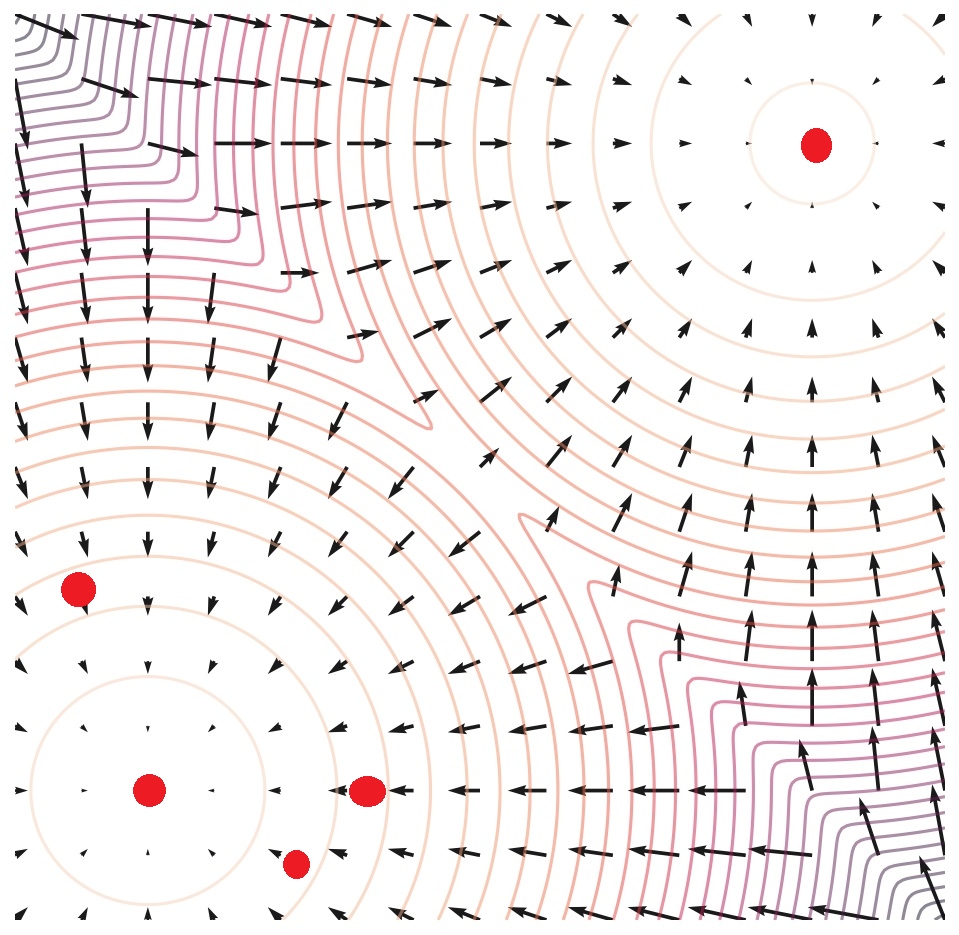

This is what the process might look like, and we can immediately see a new problem: everything get's sent to a few score extremes, rather than a distribution.

The simple fix, presented without derivation, is to use Langevin Dynamics for the sampling. This is implemented as follows: $\tilde{x}_{n+1} = \tilde{x} + \alpha s_\theta(\tilde x) + \sqrt{2\alpha}\epsilon$ for $\epsilon = \mathcal N \sim (0,\sigma^2 I)$

Now the final point is how to pick our noise. If we pick a small amount of noise, we don't explore enough of our sample manifold. If we pick too much noise, we destroy our original distribution.

The simple solution is to simply not fix our $\sigma$, and have it vary. This requires almost no modification to the previous work we did. We just modify our score network to be conditioned on the noise $s_\theta (\tilde x, \sigma)$

With $\tilde x = x + \epsilon$ where $\epsilon = \mathcal N (0, \sigma^2_t I)$ where $t$ is an index for our noise levels.

In [ ]:
Image(url='https://yang-song.net/assets/img/score/ald.gif')

So now a question you might ask is how many noise levels to use? The original proposals for this score matching used 1000 steps. A natural formulation is to simply let the number of noise levels go to infinity and consider a continuous noise scale.

In this case we can describe our noising process as an Ito stochastic differential equation.

$dX = f(X,t)dt + g(X,t)dW$

# TODO Yang 2020 paper connection

Without going into detail, $X$ is a random variable, $f$ is a drift term, and $g$ is the diffusion term, and $dW$ is a Weiner process (also called brownian motion) and for the purposes of this talk can be considered a normally distributed noise.

This equation takes our input data and noises it, and we can call it the forward SDE.

There is an associated backwards SDE for this equation found by Bryan Anderson in 1982. We will take it as a given.

$dX = \left[f(x,t) -g^2(t)\nabla_x \log p_\sigma (x)\right]dt + g(t) dW$

The main takeway is we have a continuous process that noises our data and a processes that denoises it. And it includes our score function.

# Connection to DDPM

The DDPM (Denoising Diffusion Probabilsitic Models) paper uses a the following sampling method.

$x_t = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon, \epsilon \sim \mathcal N (0,1)$

This can be converted into the continuous time case.

$x_t = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon$

$x_t - x_{t-1} = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon - x_{t-1}$

Taylor Expand $ \sqrt{1-\beta_t}x_{t-1} = \left(1 - \dfrac12\beta_t\right)$

$x_t - x_{t-1} = \left(1 - \dfrac12\beta_t\right)x_{t-1} + \sqrt{\beta_t}\epsilon - x_{t-1}$

$x_t - x_{t-1} = \dfrac12\beta(t)x_{t-1} + \sqrt{\beta(t)}\epsilon$

Squeeze $x_t-x_{t-1}$ to 0 gives

$dx =  \dfrac12\beta_tx dt + \sqrt{\beta_t}dW$

Plugging this into our reverse SDE yields

$dx = -\dfrac12\beta(t)dt - \beta(t)\nabla_x\log p_\sigma (x)dt + \sqrt{\beta(t)}dW$







